In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,StandardScaler,LabelEncoder,RobustScaler
from sklearn.metrics import accuracy_score,roc_auc_score
from sklearn.model_selection import cross_val_score,KFold,train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from skopt import BayesSearchCV
from skopt.space import Categorical
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm
import warnings


In [84]:
df = pd.read_csv("TitanicDF.csv")
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Objetivo
O objetivo deste modelo de machine learning é superar uma abordagem simples, que classifica todas as mulheres como sobreviventes e todos os homens como mortos, com base em nossa análise exploratória dos dados. Embora essa abordagem inicial forneça uma linha de base simples, nosso objetivo é desenvolver um modelo mais sofisticado e preciso, que leve em consideração as várias características dos passageiros, como idade, classe social, tarifa do bilhete, entre outras variáveis, para prever com maior exatidão a probabilidade de sobrevivência de cada indivíduo.

Nosso modelo será avaliado usando métricas como precisão, recall, F1-score e AUC-ROC, buscando não apenas uma melhoria na acurácia, mas também uma abordagem balanceada que considere possíveis desbalanceamentos nas classes de sobreviventes e mortos. Esperamos que, ao aplicar técnicas avançadas de machine learning, como regressão logística, árvores de decisão, florestas aleatórias e modelos de ensemble, possamos obter um modelo robusto que supere a linha de base inicial.


In [81]:
objective = round((df.loc[(df["Sex"]=="female") & (df["Survived"]==1),:].count()[0] + df.loc[(df["Sex"]=="male") & (df["Survived"]==0),:].count()[0]) / len(df) * 100,2)

C:\Users\Lucas\AppData\Local\Temp\ipykernel_21400\36471988.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  objective = round((df.loc[(df["Sex"]=="female") & (df["Survived"]==1),:].count()[0] + df.loc[(df["Sex"]=="male") & (df["Survived"]==0),:].count()[0]) / len(df) * 100,2)
C:\Users\Lucas\AppData\Local\Temp\ipykernel_21400\36471988.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  objective = round((df.loc[(df["Sex"]=="female") & (df["Survived"]==1),:].count()[0] + df.loc[(df["Sex"]=="male") & (df["Survived"]==0),:].count()[0]) / len(df) * 100,2)


In [82]:
print(f'The percentage of the dead: {objective}%')

The percentage of the dead: 78.68%


# Cleaning the Data

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
pd.DataFrame(round(df.isnull().sum()/df.count()[0],3),columns=['% of Nulls'])

C:\Users\Lucas\AppData\Local\Temp\ipykernel_21400\2168987199.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pd.DataFrame(round(df.isnull().sum()/df.count()[0],3),columns=['% of Nulls'])


,% of Nulls
PassengerId,0.000
Survived,0.000
Pclass,0.000
Name,0.000
Sex,0.000
Age,0.199
SibSp,0.000
Parch,0.000
Ticket,0.000
Fare,0.000


In [8]:
df.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S


Observando as colunas, nós podemos ver que algumas delas não tem utilidade a nós, como a de Nome,Ticket e o ID do passageiro. Seria interessante nós termos a cabine, pois de acordo com a localização da cabine poderia haver uma predição melhor, cabines mais perto dos botes de salva-vidas poderiam ter uma maior chance de sobrevivência, entretanto, pelo elevado valor de nulos, não é interessante nós mantermos a coluna cabine na nossa predição.

In [9]:
df.drop(['Cabin','Ticket','Name','PassengerId'],axis=1,inplace=True)

Cerca de 20% dos valores de idade são nulos, não creio que eliminar todos os valores nulos é interessante, então eu substitui os valores nulos pela mediana. Além disso, nós buscamos implementar a mediana pela classe em que o passageiro estava, pois algumas classes havia passageiros mais novos, creio que esta foi a melhor forma de manter o máximo possivel a integridade.

In [10]:
df.groupby('Pclass')['Age'].median()

Pclass
1    37.0
2    29.0
3    24.0
Name: Age, dtype: float64

In [11]:
df.groupby('Pclass')['Age'].median()[1]

37.0

In [12]:
df.loc[(df['Pclass']==3) & (df['Age'].isnull()),'Age'] = df.groupby('Pclass')['Age'].median()[3]
df.loc[(df['Pclass']==2) & (df['Age'].isnull()),'Age'] = df.groupby('Pclass')['Age'].median()[2]
df.loc[(df['Pclass']==1) & (df['Age'].isnull()),'Age'] = df.groupby('Pclass')['Age'].median()[1]

In [13]:
df = df.drop(df.loc[df['Embarked'].isnull(),:].index,axis=0)

In [14]:
target = df['Survived'].values
df.drop('Survived',axis=1,inplace=True)


Agora, nós vamos dropar os 0,2% de valores de embarcados que contem valores nulos, como há muito poucos valores, isso não vai afetar a nossa analise.
Além disso, um processo que nós iamos fazer no preprocessamento, eu já vou começar aqui pois logo em seguida eu vou dropar a coluna.

## PreProcessing

In [15]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,StandardScaler,LabelEncoder,RobustScaler
kfold = KFold(n_splits=20,random_state=0,shuffle=True)

In [16]:
scaler = StandardScaler()
scaler2 = RobustScaler()
df['Sex'] = LabelEncoder().fit_transform(df['Sex'])
df['Embarked'] = LabelEncoder().fit_transform(df['Embarked'])
df3 = df.copy()


In [17]:
df['Age'] = scaler.fit_transform(df.iloc[:,3:4])
df['Fare'] = scaler.fit_transform(df.iloc[:,6:7])

Nós precisamos utilizar o StandardScaler, nós vimos anteriormente que hávia uma diferença de magnitude entre as colunas Age e Fare, o que pode fazer que nosso modelo de Machine Learning priorize a Coluna Fare, assim prejudicando o modelo. Além disso, foi necessário utilizar o LabelEncoder para transformar nossas variaveis categóricas em numéricas.

In [18]:
transformer = ColumnTransformer(
    transformers=[
        ('OneHot', OneHotEncoder(sparse_output=False), ['Pclass', 'Sex','Embarked']),
        ('RobustScaler',RobustScaler(),['SibSp','Parch'])
    ],
    remainder='passthrough',
)

In [19]:
predict1 = (transformer.fit_transform(df))

In [20]:
predict2 = df.iloc[:,1::].values

In [21]:
predict3 = df3.values

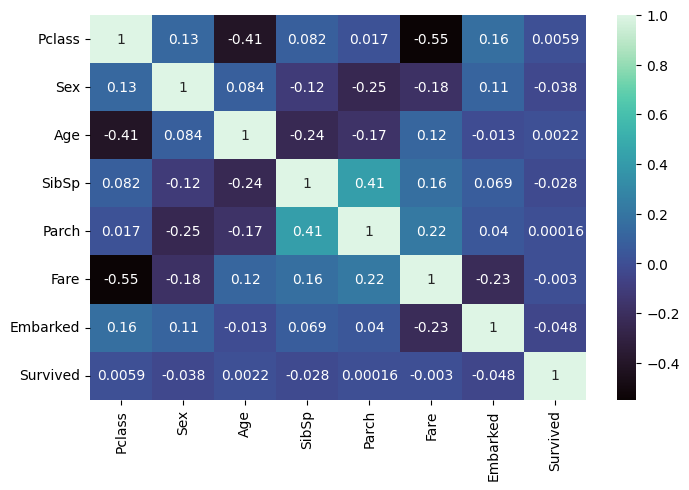

In [89]:
df4 = pd.concat([df3,pd.DataFrame(target,columns=["Survived"])],axis=1)
fig = plt.figure(figsize=(8,5))
sns.heatmap(df4.corr(method='pearson'),annot=True,cmap="mako");

Para comparar no final, nós vamos utilizar os atributos escalacionados e os atributos
- Predict1: OneHot em Pclass,Sex,Embarked. RobustScaler em SibSP e Parch. StandardScaler em Age e Fare. 
- Predict2: LabelEnconder em Sex e Embarked. StandardScaler em Age e Fare
- Predict3: LabelEnconder em Sex e Embarked.

# Processo de experimentação com os estimators
Para o processo de experimentação, escolhemos 10 modelos diferentes com o objetivo de avaliar qual se adapta melhor ao nosso conjunto de dados. Dentre esses modelos, alguns tendem a aumentar a variância enquanto diminuem o erro, e vice-versa. Além disso, temos modelos que lidam de maneira mais eficaz com classes desbalanceadas. Embora, no nosso caso, o desbalanceamento entre as classes não seja muito pronunciado (embora haja um número maior de mortos, a diferença não é tão expressiva), é importante considerar como os modelos se comportam em situações desse tipo.

Uma consideração importante é que alguns dos modelos selecionados são baseados em distâncias, como o KNN (K-Nearest Neighbors) e a Máquina de Vetores de Suporte (SVM). Modelos baseados em distância, como o KNN, calculam a similaridade entre pontos de dados com base na proximidade, o que pode ser sensível ao escalonamento das variáveis. Caso as variáveis não estejam devidamente escaladas, isso pode levar a modelos imprecisos ou distorcidos, já que os algoritmos podem ser influenciados pela diferença de unidades de medida ou a magnitude dos valores das variáveis. Por isso, esses preditores precisam ser analisados com atenção, principalmente se os dados não foram pré-processados adequadamente.

**Modelos Selecionados e Suas Características**

- Naive Bayes: Este é um modelo simples e de fácil interpretação, com um baixo impacto de variáveis irrelevantes. Ele não exige grandes volumes de dados, o que é uma vantagem no nosso caso, já que temos um conjunto de dados relativamente pequeno. No entanto, uma desvantagem do Naive Bayes é que ele assume a independência entre as variáveis (colunas). Em muitos cenários, isso pode ser uma limitação, mas no nosso caso, a correlação entre as variáveis é relativamente baixa, sendo a mais forte em torno de -0,55. Isso significa que a suposição de independência não deve prejudicar muito o desempenho do modelo, mas ainda assim deve ser considerada ao avaliarmos sua precisão.

- Máquina de Vetores de Suporte (SVM) e KNN: Esses modelos foram incluídos principalmente para entender como eles se comportam com os nossos dados. Como mencionado, algumas variáveis não foram escaladas, o que pode afetar o desempenho de algoritmos baseados em distâncias. Caso não haja o escalonamento adequado, o KNN pode gerar um modelo impreciso, já que ele depende diretamente das distâncias entre os pontos de dados. Além disso, queríamos avaliar a robustez da Máquina de Vetores de Suporte (SVM) a outliers. O SVM tende a ser sensível a outliers, mas também pode ser eficaz na identificação de padrões em dados mais complexos, desde que haja uma regularização apropriada.




## Gaussian Naive Bayes

In [23]:
result1 = pd.DataFrame(columns=['Model','TrainScore','AccuracyScore','CrossValScore'])
result2 = pd.DataFrame(columns=['Model','TrainScore','AccuracyScore','CrossValScore'])
result3 = pd.DataFrame(columns=['Model','TrainScore','AccuracyScore','CrossValScore'])
x_train,x_test,y_train,y_test = train_test_split(predict1,target,test_size=0.3,random_state=0)
gb = GaussianNB()
gb.fit(x_train,y_train)
result1.loc[0] = ['Gaussian NB',accuracy_score(y_train,gb.predict(x_train)),accuracy_score(y_test,gb.predict(x_test)),cross_val_score(gb,predict1,target,scoring='roc_auc',cv=kfold).mean()]
x_train,x_test,y_train,y_test = train_test_split(predict2,target,test_size=0.3,random_state=0)
gb.fit(x_train,y_train)
result2.loc[0] = ['Gaussian NB',accuracy_score(y_train,gb.predict(x_train)),accuracy_score(y_test,gb.predict(x_test)),cross_val_score(gb,predict2,target,scoring='roc_auc',cv=kfold).mean()]
x_train,x_test,y_train,y_test = train_test_split(predict3,target,test_size=0.3,random_state=0)
gb.fit(x_train,y_train)
result3.loc[0] = ['Gaussian NB',accuracy_score(y_train,gb.predict(x_train)),accuracy_score(y_test,gb.predict(x_test)),cross_val_score(gb,predict3,target,scoring='roc_auc',cv=kfold).mean()]

## Maquina Vetor

In [24]:

x_train,x_test,y_train,y_test = train_test_split(predict1,target,test_size=0.3,random_state=0)
sv = SVC(C=1,kernel='rbf')
sv.fit(x_train,y_train)
result1.loc[1] = ['Support Vector Machine',accuracy_score(y_train,sv.predict(x_train)),accuracy_score(y_test,sv.predict(x_test)),cross_val_score(sv,predict1,target,cv=kfold).mean()]
x_train,x_test,y_train,y_test = train_test_split(predict2,target,test_size=0.3,random_state=0)
sv = SVC(C=1,kernel='rbf')
sv.fit(x_train,y_train)
result2.loc[1] = ['Support Vector Machine',accuracy_score(y_train,sv.predict(x_train)),accuracy_score(y_test,sv.predict(x_test)),cross_val_score(sv,predict2,target,cv=kfold).mean()]
x_train,x_test,y_train,y_test = train_test_split(predict3,target,test_size=0.3,random_state=0)
sv = SVC(C=1,kernel='linear')
sv.fit(x_train,y_train)
result3.loc[1] = ['Support Vector Machine',accuracy_score(y_train,sv.predict(x_train)),accuracy_score(y_test,sv.predict(x_test)),cross_val_score(sv,predict3,target,cv=kfold).mean()]

## KNN

In [25]:
x_train,x_test,y_train,y_test = train_test_split(predict1,target,test_size=0.3,random_state=0)
knn = KNeighborsClassifier(n_neighbors=20,leaf_size=5,p=1)
knn.fit(x_train,y_train)
result1.loc[2] = ['KNN',accuracy_score(y_train,knn.predict(x_train)),accuracy_score(y_test,knn.predict(x_test)),cross_val_score(knn,predict1,target,cv=kfold).mean()]
x_train,x_test,y_train,y_test = train_test_split(predict2,target,test_size=0.3,random_state=0)
knn = KNeighborsClassifier(n_neighbors=40,leaf_size=18,p=4)
knn.fit(x_train,y_train)
result2.loc[2] = ['KNN',accuracy_score(y_train,knn.predict(x_train)),accuracy_score(y_test,knn.predict(x_test)),cross_val_score(knn,predict2,target,cv=kfold).mean()]
x_train,x_test,y_train,y_test = train_test_split(predict3,target,test_size=0.3,random_state=0)
knn = KNeighborsClassifier(n_neighbors=11,leaf_size=8,p=1)
knn.fit(x_train,y_train)
result3.loc[2] = ['KNN',accuracy_score(y_train,knn.predict(x_train)),accuracy_score(y_test,knn.predict(x_test)),cross_val_score(knn,predict3,target,cv=kfold).mean()]




## Decision Tree

In [26]:
from sklearn.tree import DecisionTreeClassifier

In [27]:
x_train,x_test,y_train,y_test = train_test_split(predict1,target,test_size=0.3,random_state=0)
tree2 = DecisionTreeClassifier(criterion='entropy',max_depth=3,random_state=0)
tree2.fit(x_train,y_train)
result1.loc[3] = ['Decision Tree',accuracy_score(y_train,tree2.predict(x_train)),accuracy_score(y_test,tree2.predict(x_test)),cross_val_score(tree2,predict1,target,cv=kfold).mean()]
x_train,x_test,y_train,y_test = train_test_split(predict2,target,test_size=0.3,random_state=0)
tree2 = DecisionTreeClassifier(criterion='log_loss',max_depth=4,random_state=0)
tree2.fit(x_train,y_train)
result2.loc[3] = ['Decision Tree',accuracy_score(y_train,tree2.predict(x_train)),accuracy_score(y_test,tree2.predict(x_test)),cross_val_score(tree2,predict2,target,cv=kfold).mean()]
x_train,x_test,y_train,y_test = train_test_split(predict3,target,test_size=0.3,random_state=0)
tree2 = DecisionTreeClassifier(criterion='log_loss',max_depth=3,random_state=0)
tree2.fit(x_train,y_train)
result3.loc[3] = ['Decision Tree',accuracy_score(y_train,tree2.predict(x_train)),accuracy_score(y_test,tree2.predict(x_test)),cross_val_score(tree2,predict3,target,cv=kfold).mean()]

## Random Forest

In [28]:
from sklearn.ensemble import RandomForestClassifier
tree = RandomForestClassifier()
x_train,x_test,y_train,y_test = train_test_split(predict1,target,test_size=0.3,random_state=0)
treer = RandomForestClassifier(n_estimators=51,criterion='log_loss',max_depth=3,max_features='log2')
treer.fit(x_train,y_train)
result1.loc[4] = ['Random Forest',accuracy_score(y_train,treer.predict(x_train)),accuracy_score(y_test,treer.predict(x_test)),cross_val_score(treer,predict1,target,cv=kfold).mean()]
x_train,x_test,y_train,y_test = train_test_split(predict2,target,test_size=0.3,random_state=0)
treer = RandomForestClassifier(n_estimators=52,criterion='entropy',max_depth=2,max_features='log2')
treer.fit(x_train,y_train)
result2.loc[4] = ['Random Forest',accuracy_score(y_train,treer.predict(x_train)),accuracy_score(y_test,treer.predict(x_test)),cross_val_score(treer,predict2,target,cv=kfold).mean()]
x_train,x_test,y_train,y_test = train_test_split(predict3,target,test_size=0.3,random_state=0)
treer = RandomForestClassifier(n_estimators=147,criterion='entropy',max_depth=4,max_features='sqrt')
treer.fit(x_train,y_train)
result3.loc[4] = ['Random Forest',accuracy_score(y_train,treer.predict(x_train)),accuracy_score(y_test,treer.predict(x_test)),cross_val_score(treer,predict3,target,cv=kfold).mean()]

In [29]:
x_train,x_test,y_train,y_test = train_test_split(predict3,target,test_size=0.3,random_state=0)

## XGBoost

In [30]:
from xgboost import XGBClassifier

In [31]:
x_train,x_test,y_train,y_test = train_test_split(predict1,target,test_size=0.3,random_state=0)
XG = XGBClassifier(learning_rate=0.14,max_depth=3,n_estimators=10,gamma=0.5,random_state=0,subsample=1)
XG.fit(x_train,y_train)
result1.loc[5] = ['XGBOOST',accuracy_score(y_train,XG.predict(x_train)),accuracy_score(y_test,XG.predict(x_test)),cross_val_score(XG,predict1,target,cv=kfold).mean()]
x_train,x_test,y_train,y_test = train_test_split(predict2,target,test_size=0.3,random_state=0)
XG = XGBClassifier(learning_rate=0.01,max_depth=3,n_estimators=100,gamma=0,random_state=0,subsample=1)
XG.fit(x_train,y_train)
result2.loc[5] = ['XGBOOST',accuracy_score(y_train,XG.predict(x_train)),accuracy_score(y_test,XG.predict(x_test)),cross_val_score(XG,predict2,target,cv=kfold).mean()]
x_train,x_test,y_train,y_test = train_test_split(predict3,target,test_size=0.3,random_state=0)
XG = XGBClassifier(learning_rate=0.01,max_depth=3,n_estimators=100,gamma=0,random_state=0,subsample=1)
XG.fit(x_train,y_train)
result3.loc[5] = ['XGBOOST',accuracy_score(y_train,XG.predict(x_train)),accuracy_score(y_test,XG.predict(x_test)),cross_val_score(XG,predict3,target,cv=kfold).mean()]

## Gradient Boost

In [32]:
from sklearn.ensemble import GradientBoostingClassifier

In [33]:
x_train,x_test,y_train,y_test = train_test_split(predict1,target,test_size=0.3,random_state=0)
GBC = GradientBoostingClassifier(learning_rate=0.01,max_depth=3,n_estimators=100,criterion='squared_error')
GBC.fit(x_train,y_train)
result1.loc[6] = ['Gradient Boost',accuracy_score(y_train,GBC.predict(x_train)),accuracy_score(y_test,GBC.predict(x_test)),cross_val_score(GBC,predict1,target,cv=kfold).mean()]
x_train,x_test,y_train,y_test = train_test_split(predict2,target,test_size=0.3,random_state=0)
GBC = GradientBoostingClassifier(learning_rate=0.12,max_depth=2,n_estimators=100,criterion='squared_error')
GBC.fit(x_train,y_train)
result2.loc[6] = ['Gradient Boost',accuracy_score(y_train,GBC.predict(x_train)),accuracy_score(y_test,GBC.predict(x_test)),cross_val_score(GBC,predict2,target,cv=kfold).mean()]
x_train,x_test,y_train,y_test = train_test_split(predict3,target,test_size=0.3,random_state=0)
GBC = GradientBoostingClassifier(learning_rate=0.12,max_depth=2,n_estimators=50,criterion='squared_error')
GBC.fit(x_train,y_train)
result3.loc[6] = ['Gradient Boost',accuracy_score(y_train,GBC.predict(x_train)),accuracy_score(y_test,GBC.predict(x_test)),cross_val_score(GBC,predict3,target,cv=kfold).mean()]

## LightGBM

In [34]:
import lightgbm
x_train,x_test,y_train,y_test = train_test_split(predict1,target,test_size=0.3,random_state=0)
lgb2 = lightgbm.LGBMClassifier(learning_rate=0.005,max_depth=10,n_estimators=202,num_leaves=72,random_state=0)
lgb2.fit(x_train,y_train)
result1.loc[7] = ['LightGBM',accuracy_score(y_train,lgb2.predict(x_train)),accuracy_score(y_test,lgb2.predict(x_test)),cross_val_score(lgb2,predict1,target,cv=kfold).mean()]
x_train,x_test,y_train,y_test = train_test_split(predict2,target,test_size=0.3,random_state=0)
lgb2 = lightgbm.LGBMClassifier(learning_rate=0.005,max_depth=6,n_estimators=541,num_leaves=180,random_state=0)
lgb2.fit(x_train,y_train)
result2.loc[7] = ['LightGBM',accuracy_score(y_train,lgb2.predict(x_train)),accuracy_score(y_test,lgb2.predict(x_test)),cross_val_score(lgb2,predict2,target,cv=kfold).mean()]
x_train,x_test,y_train,y_test = train_test_split(predict3,target,test_size=0.3,random_state=0)
lgb2 = lightgbm.LGBMClassifier(learning_rate=0.006,max_depth=3,n_estimators=474,num_leaves=10,random_state=0)
lgb2.fit(x_train,y_train)
result3.loc[7] = ['LightGBM',accuracy_score(y_train,lgb2.predict(x_train)),accuracy_score(y_test,lgb2.predict(x_test)),cross_val_score(lgb2,predict3,target,cv=kfold).mean()]


[LightGBM] [Info] Number of positive: 230, number of negative: 392
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001316 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 42
[LightGBM] [Info] Number of data points in the train set: 622, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.369775 -> initscore=-0.533183
[LightGBM] [Info] Start training from score -0.533183
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


## Regressão Logística

In [35]:
from sklearn.linear_model import LogisticRegression

In [36]:
x_train,x_test,y_train,y_test = train_test_split(predict1,target,test_size=0.3,random_state=0)
logistic = LogisticRegression(C=2,penalty='l2',solver='liblinear',max_iter=100)
logistic.fit(x_train,y_train)
result1.loc[8] = ['LogisticRegression',accuracy_score(y_train,logistic.predict(x_train)),accuracy_score(y_test,logistic.predict(x_test)),cross_val_score(logistic,predict1,target,cv=kfold).mean()]
x_train,x_test,y_train,y_test = train_test_split(predict2,target,test_size=0.3,random_state=0)
logistic = LogisticRegression(C=2,penalty='l2',solver='liblinear',max_iter=100)
logistic.fit(x_train,y_train)
result2.loc[8] = ['LogisticRegression',accuracy_score(y_train,logistic.predict(x_train)),accuracy_score(y_test,logistic.predict(x_test)),cross_val_score(logistic,predict2,target,cv=kfold).mean()]
x_train,x_test,y_train,y_test = train_test_split(predict3,target,test_size=0.3,random_state=0)
logistic = LogisticRegression(C=20,penalty='l2',solver='liblinear',max_iter=100)
logistic.fit(x_train,y_train)
result3.loc[8] = ['LogisticRegression',accuracy_score(y_train,logistic.predict(x_train)),accuracy_score(y_test,logistic.predict(x_test)),cross_val_score(logistic,predict3,target,cv=kfold).mean()]

## Neural Classifier

In [37]:
from sklearn.neural_network import MLPClassifier
x_train,x_test,y_train,y_test = train_test_split(predict1,target,test_size=0.3,random_state=0)
GDC = MLPClassifier(activation='relu',hidden_layer_sizes=(60,60),learning_rate='adaptive',solver='sgd')
GDC.fit(x_train,y_train)
result1.loc[9] = ['Neural Classifier',accuracy_score(y_train,GDC.predict(x_train)),accuracy_score(y_test,GDC.predict(x_test)),cross_val_score(GDC,predict1,target,cv=kfold).mean()]
x_train,x_test,y_train,y_test = train_test_split(predict2,target,test_size=0.3,random_state=0)
GDC = MLPClassifier(activation='tanh',hidden_layer_sizes=(50,50),learning_rate='adaptive',solver='adam')
GDC.fit(x_train,y_train)
result2.loc[9] = ['Neural Classifier',accuracy_score(y_train,GDC.predict(x_train)),accuracy_score(y_test,GDC.predict(x_test)),cross_val_score(GDC,predict2,target,cv=kfold).mean()]


# Análise dos Estimators com diferentes preditores

### Analyzing predictors


In [38]:
result1['overfittest'] = (result1['TrainScore'] - result1["CrossValScore"]) * 100
result2['overfittest'] = (result2['TrainScore'] - result2["CrossValScore"]) * 100
result3['overfittest'] = (result3['TrainScore'] - result3["CrossValScore"]) * 100

In [39]:
result1.describe()

,TrainScore,AccuracyScore,CrossValScore,overfittest
count,10.000000,10.000000,10.000000,10.000000
mean,0.818650,0.766292,0.802618,1.603126
std,0.013404,0.005056,0.012098,2.059440
min,0.789389,0.760300,0.786313,-3.919254
25%,0.814309,0.761236,0.798169,1.533362
50%,0.824759,0.767790,0.801010,2.172432
75%,0.826367,0.767790,0.807184,2.632243
max,0.831190,0.775281,0.828582,3.356345


In [40]:
result2.describe()

,TrainScore,AccuracyScore,CrossValScore,overfittest
count,10.000000,10.000000,10.000000,10.000000
mean,0.803537,0.769663,0.792170,1.136727
std,0.017706,0.013475,0.010962,1.378838
min,0.765273,0.734082,0.765985,-2.660054
25%,0.803859,0.767790,0.788556,1.195417
50%,0.811093,0.773408,0.793106,1.462430
75%,0.814711,0.775281,0.799280,1.714131
max,0.818328,0.782772,0.804343,2.123218


In [41]:
result3.describe()

,TrainScore,AccuracyScore,CrossValScore,overfittest
count,9.000000,9.000000,9.000000,9.000000
mean,0.833333,0.771119,0.803658,2.967511
std,0.030631,0.030796,0.031203,2.194480
min,0.782958,0.696629,0.728864,-1.802181
25%,0.807074,0.771536,0.796490,2.822648
50%,0.847267,0.782772,0.813434,3.167747
75%,0.858521,0.786517,0.824596,3.874809
max,0.868167,0.797753,0.826843,5.473286


In [42]:
result1.sort_values(by="CrossValScore",ascending=False)

,Model,TrainScore,AccuracyScore,CrossValScore,overfittest
0,Gaussian NB,0.789389,0.760300,0.828582,-3.919254
7,LightGBM,0.821543,0.764045,0.811136,1.040704
6,Gradient Boost,0.824759,0.767790,0.807753,1.700632
5,XGBOOST,0.824759,0.767790,0.805480,1.927904
2,KNN,0.826367,0.767790,0.802197,2.416959
4,Random Forest,0.827974,0.771536,0.799823,2.815104
3,Decision Tree,0.826367,0.775281,0.799798,2.656858
1,Support Vector Machine,0.831190,0.767790,0.797626,3.356345
9,Neural Classifier,0.802251,0.760300,0.787475,1.477606
8,LogisticRegression,0.811897,0.760300,0.786313,2.558397


In [43]:
result2.sort_values(by="CrossValScore",ascending=False)

,Model,TrainScore,AccuracyScore,CrossValScore,overfittest
3,Decision Tree,0.818328,0.767790,0.804343,1.398454
5,XGBOOST,0.813505,0.775281,0.802096,1.140886
1,Support Vector Machine,0.815113,0.775281,0.799848,1.526406
9,Neural Classifier,0.813505,0.775281,0.797576,1.592907
6,Gradient Boost,0.815113,0.779026,0.794242,2.087012
8,LogisticRegression,0.803859,0.767790,0.791970,1.188882
0,Gaussian NB,0.765273,0.734082,0.791874,-2.660054
7,LightGBM,0.808682,0.771536,0.787449,2.123218
4,Random Forest,0.803859,0.767790,0.786313,1.754539
2,KNN,0.778135,0.782772,0.765985,1.215020


In [44]:
result3.sort_values(by="CrossValScore",ascending=False)

,Model,TrainScore,AccuracyScore,CrossValScore,overfittest
7,LightGBM,0.858521,0.786517,0.826843,3.167747
0,Gaussian NB,0.807074,0.752809,0.825096,-1.802181
4,Random Forest,0.863344,0.786517,0.824596,3.874809
5,XGBOOST,0.847267,0.797753,0.819040,2.822648
6,Gradient Boost,0.868167,0.782772,0.813434,5.473286
3,Decision Tree,0.847267,0.790262,0.812273,3.499415
8,LogisticRegression,0.824759,0.775281,0.796490,2.826894
1,Support Vector Machine,0.800643,0.771536,0.786288,1.435521
2,KNN,0.782958,0.696629,0.728864,5.409456


**Observações sobre os Resultados e os Previsores**

Podemos observar que as pontuações de acurácia para os previsores Predict1, Predict2 e Predict3 não diferiram significativamente; no entanto, o STD maior nos resultados de Predict3 indica uma maior variância na acurácia dos modelos. Isso provavelmente ocorre porque alguns modelos, como K-Nearest Neighbors (KNN) e Support Vector Machines (SVM), não apresentam desempenho ideal em conjuntos de dados sem valores escalonados, como evidenciado na tabela de resultados de Predict3.

O conjunto de previsores com o melhor desempenho na validação cruzada foi o Predict1, provavelmente devido à aplicação do OneHotEncoder e de outras técnicas de pré-processamento, que contribuem para melhorar a acurácia do modelo.

**Análise de Overfitting nos Resultados**

Os resultados de Predict3 também apresentaram os maiores níveis de overfitting, o que pode ser atribuído à ausência de métodos adequados de codificação e escalonamento para este conjunto de dados. Isso reduziu a capacidade de generalização dos modelos treinados. Apesar disso, ainda existem modelos em Predict3 que obtiveram boas pontuações de validação cruzada, o que destaca como determinados tipos de modelos e práticas de pré-processamento podem influenciar tanto o overfitting quanto a robustez do modelo.



# Selecionando o Estimator

C:\Users\Lucas\AppData\Local\Temp\ipykernel_21400\3233816372.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=ax1,y=result1.sort_values(by="CrossValScore",ascending=False)["Model"],x=result1.sort_values(by="CrossValScore",ascending=False)["CrossValScore"],palette="ch:start=.2,rot=-.3")
C:\Users\Lucas\AppData\Local\Temp\ipykernel_21400\3233816372.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=result1.sort_values(by="CrossValScore",ascending=False).head(5)["Model"],y=result1.sort_values(by="CrossValScore",ascending=False).head(5)["overfittest"],palette="ch:start=.2,rot=-.3")


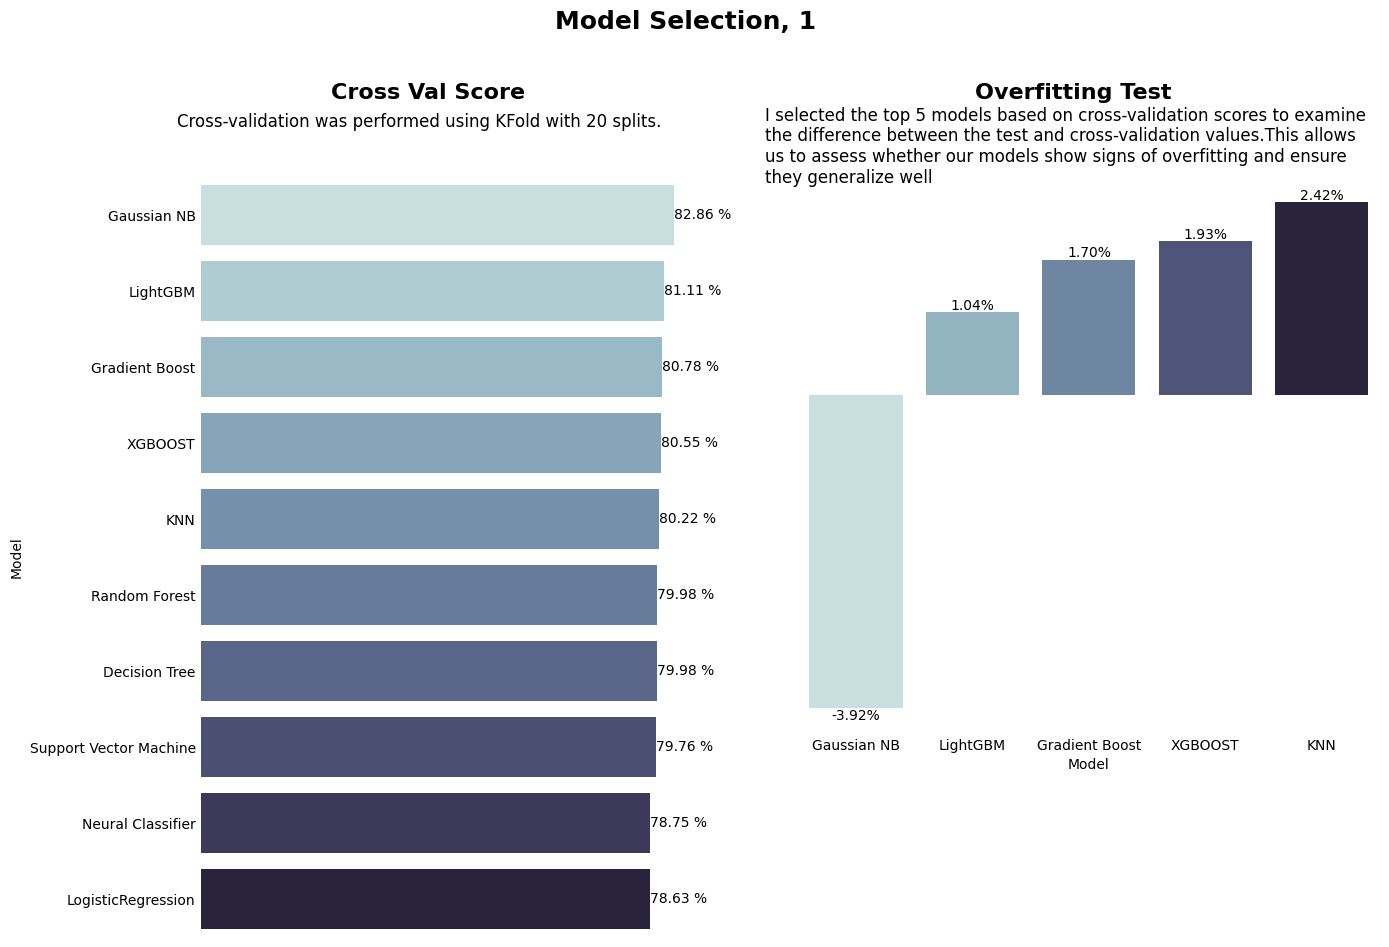

In [45]:
fig = plt.figure(figsize=(14,14))
gs = fig.add_gridspec(14,14)
ax1 = fig.add_subplot(gs[2:10,0:6])
ax2 = fig.add_subplot(gs[2:8,7:14])
axt = [ax1,ax2]
ax1.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
for i in axt:
    for j in ["top","right","bottom","left"]:
        i.spines[j].set_visible(False)
sns.barplot(ax=ax1,y=result1.sort_values(by="CrossValScore",ascending=False)["Model"],x=result1.sort_values(by="CrossValScore",ascending=False)["CrossValScore"],palette="ch:start=.2,rot=-.3")
sns.barplot(x=result1.sort_values(by="CrossValScore",ascending=False).head(5)["Model"],y=result1.sort_values(by="CrossValScore",ascending=False).head(5)["overfittest"],palette="ch:start=.2,rot=-.3")
ax1.tick_params(length=0)
ax2.tick_params(length=0)
fig.text(0.7,0.9,"Overfitting Test",weight="bold",fontsize=16)
fig.text(0.55,0.84,"I selected the top 5 models based on cross-validation scores to examine\nthe difference between the test and cross-validation values.This allows\nus to assess whether our models show signs of overfitting and ensure\nthey generalize well ",fontsize=12)         
fig.text(0.24,0.9,"Cross Val Score",weight="bold",fontsize=16)
fig.text(0.13,0.88,"Cross-validation was performed using KFold with 20 splits.",fontsize=12)
fig.text(0.40,0.95,"Model Selection, 1",weight="bold",fontsize=18)
fig.tight_layout()
for i in ax1.containers:
    ax1.bar_label(i, fmt = lambda x: f'{x*100:.2f} %')
for i in ax2.containers:
    ax2.bar_label(i,fmt = lambda x: f'{x:.2f}%')





C:\Users\Lucas\AppData\Local\Temp\ipykernel_21400\2598718138.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=ax1,y=result2.sort_values(by="CrossValScore",ascending=False)["Model"],x=result2.sort_values(by="CrossValScore",ascending=False)["CrossValScore"],palette="ch:start=.2,rot=-.3")
C:\Users\Lucas\AppData\Local\Temp\ipykernel_21400\2598718138.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=result2.sort_values(by="CrossValScore",ascending=False).head(5)["Model"],y=result2.sort_values(by="CrossValScore",ascending=False).head(5)["overfittest"],palette="ch:start=.2,rot=-.3")


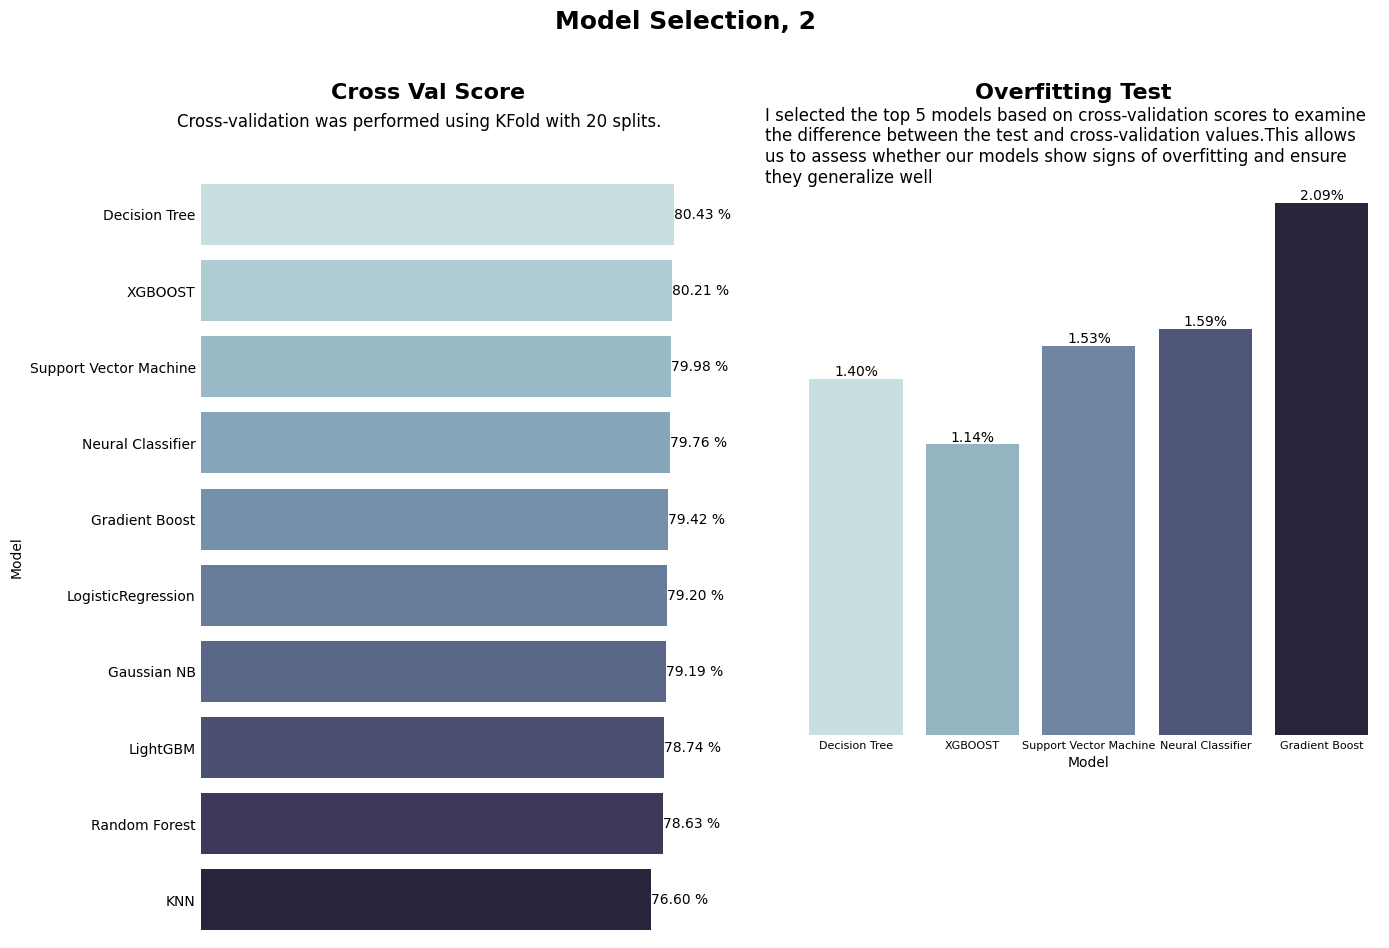

In [46]:
fig = plt.figure(figsize=(14,14))
gs = fig.add_gridspec(14,14)
ax1 = fig.add_subplot(gs[2:10,0:6])
ax2 = fig.add_subplot(gs[2:8,7:14])
axt = [ax1,ax2]
ax1.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
for i in axt:
    for j in ["top","right","bottom","left"]:
        i.spines[j].set_visible(False)
sns.barplot(ax=ax1,y=result2.sort_values(by="CrossValScore",ascending=False)["Model"],x=result2.sort_values(by="CrossValScore",ascending=False)["CrossValScore"],palette="ch:start=.2,rot=-.3")
sns.barplot(x=result2.sort_values(by="CrossValScore",ascending=False).head(5)["Model"],y=result2.sort_values(by="CrossValScore",ascending=False).head(5)["overfittest"],palette="ch:start=.2,rot=-.3")
ax1.tick_params(length=0)
ax2.tick_params(length=0)
ax2.set_xticklabels(ax2.get_xticklabels(),fontsize=8)
fig.text(0.7,0.9,"Overfitting Test",weight="bold",fontsize=16)
fig.text(0.55,0.84,"I selected the top 5 models based on cross-validation scores to examine\nthe difference between the test and cross-validation values.This allows\nus to assess whether our models show signs of overfitting and ensure\nthey generalize well ",fontsize=12)         
fig.text(0.24,0.9,"Cross Val Score",weight="bold",fontsize=16)
fig.text(0.13,0.88,"Cross-validation was performed using KFold with 20 splits.",fontsize=12)
fig.text(0.40,0.95,"Model Selection, 2",weight="bold",fontsize=18)
fig.tight_layout()
for i in ax1.containers:
    ax1.bar_label(i, fmt = lambda x: f'{x*100:.2f} %')
for i in ax2.containers:
    ax2.bar_label(i,fmt = lambda x: f'{x:.2f}%')


C:\Users\Lucas\AppData\Local\Temp\ipykernel_21400\2660107777.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=ax1,y=result3.sort_values(by="CrossValScore",ascending=False)["Model"],x=result3.sort_values(by="CrossValScore",ascending=False)["CrossValScore"],palette="ch:start=.2,rot=-.3")
C:\Users\Lucas\AppData\Local\Temp\ipykernel_21400\2660107777.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=result3.sort_values(by="CrossValScore",ascending=False).head(5)["Model"],y=result3.sort_values(by="CrossValScore",ascending=False).head(5)["overfittest"],palette="ch:start=.2,rot=-.3")


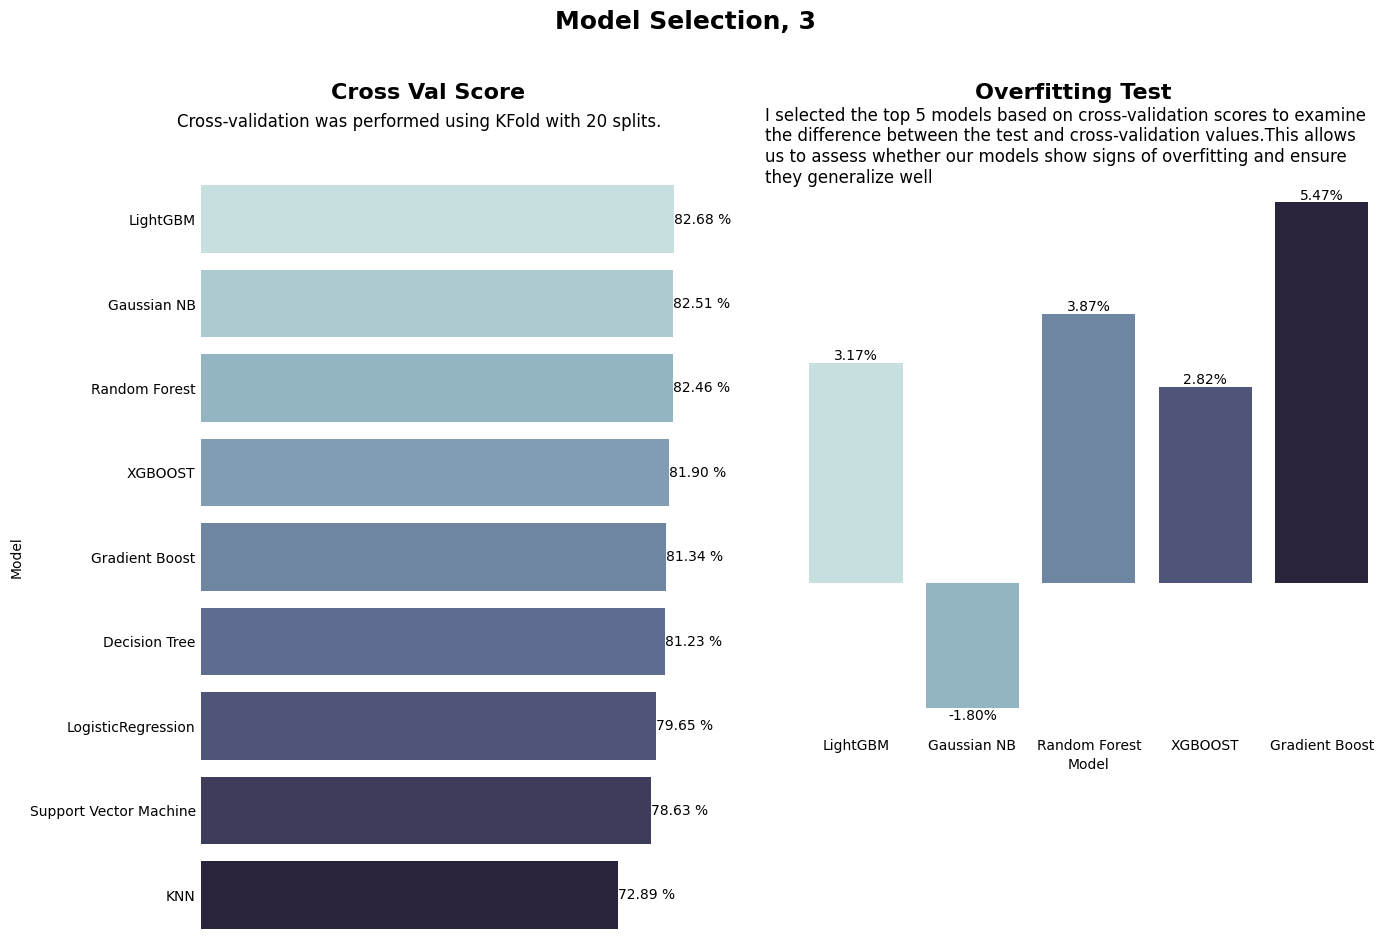

In [47]:
fig = plt.figure(figsize=(14,14))
gs = fig.add_gridspec(14,14)
ax1 = fig.add_subplot(gs[2:10,0:6])
ax2 = fig.add_subplot(gs[2:8,7:14])
axt = [ax1,ax2]
ax1.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
for i in axt:
    for j in ["top","right","bottom","left"]:
        i.spines[j].set_visible(False)
sns.barplot(ax=ax1,y=result3.sort_values(by="CrossValScore",ascending=False)["Model"],x=result3.sort_values(by="CrossValScore",ascending=False)["CrossValScore"],palette="ch:start=.2,rot=-.3")
sns.barplot(x=result3.sort_values(by="CrossValScore",ascending=False).head(5)["Model"],y=result3.sort_values(by="CrossValScore",ascending=False).head(5)["overfittest"],palette="ch:start=.2,rot=-.3")
ax1.tick_params(length=0)
ax2.tick_params(length=0)
fig.text(0.7,0.9,"Overfitting Test",weight="bold",fontsize=16)
fig.text(0.55,0.84,"I selected the top 5 models based on cross-validation scores to examine\nthe difference between the test and cross-validation values.This allows\nus to assess whether our models show signs of overfitting and ensure\nthey generalize well ",fontsize=12)         
fig.text(0.24,0.9,"Cross Val Score",weight="bold",fontsize=16)
fig.text(0.13,0.88,"Cross-validation was performed using KFold with 20 splits.",fontsize=12)
fig.text(0.40,0.95,"Model Selection, 3",weight="bold",fontsize=18)
fig.tight_layout()
for i in ax1.containers:
    ax1.bar_label(i, fmt = lambda x: f'{x*100:.2f} %')
for i in ax2.containers:
    ax2.bar_label(i,fmt = lambda x: f'{x:.2f}%')


Após a realização dos experimentos, identificamos que os modelos com melhor desempenho foram o LightGBM e o Gaussian Naive Bayes. No entanto, ao analisar as configurações dos três conjuntos de previsores criados (Predict1, Predict2 e Predict3), observamos que o Predict2 apresentou desempenho inferior, tornando-o menos interessante para uso prático.

**Por que o Predict2 teve desempenho inferior?**

A performance inferior do Predict2 pode estar associada à ausência de escalonamento em SibSp e Parch. Essas variáveis, sem o tratamento adequado, podem ter recebido um peso maior do que o ideal no modelo, impactando negativamente os resultados. Além disso, a utilização de LabelEncoder em Sex e Embarked, ao invés de OneHotEncoder, pode ter reduzido a representatividade dessas variáveis categóricas, especialmente em modelos sensíveis à relação ordinal que o LabelEncoder pode inferir erroneamente.
Em contrapartida, o Predict1, que incluiu um pré-processamento mais detalhado e consistente, proporcionou melhores resultados para os modelos.

**Propósito da Seleção Final**

Nosso objetivo é verificar se os modelos estão obtendo acurácia elevada devido à capacidade de identificar corretamente os sobreviventes ou apenas porque estão priorizando a classe majoritária (mortos). Como a classe de sobreviventes é minoritária no dataset do Titanic, é fundamental garantir que os modelos sejam eficazes em capturar os padrões das duas classes, especialmente em aplicações onde a identificação correta de sobreviventes é prioritária.
Com base nos resultados dessa análise, poderemos determinar qual combinação de modelo e conjunto de previsores é mais adequado, dependendo da finalidade prática, seja ela priorizar a identificação de sobreviventes ou reduzir falsos positivos.

# Final Selection

In [48]:
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score

In [49]:
x_train,x_test,y_train,y_test = train_test_split(predict1,target,test_size=0.3,random_state=0)
gb = GaussianNB()
gb.fit(x_train,y_train)
y_predgb = gb.predict(x_test)
x_train,x_test,y_train,y_test = train_test_split(predict3,target,test_size=0.3,random_state=0)
lgb = lightgbm.LGBMClassifier(learning_rate=0.006,max_depth=3,n_estimators=474,num_leaves=10,random_state=0)
lgb.fit(x_train,y_train)
y_predlgb = lgb.predict(x_test)

[LightGBM] [Info] Number of positive: 230, number of negative: 392
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 193
[LightGBM] [Info] Number of data points in the train set: 622, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.369775 -> initscore=-0.533183
[LightGBM] [Info] Start training from score -0.533183
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [50]:
fpr, tpr, thresholds = roc_curve(y_test, y_predgb)


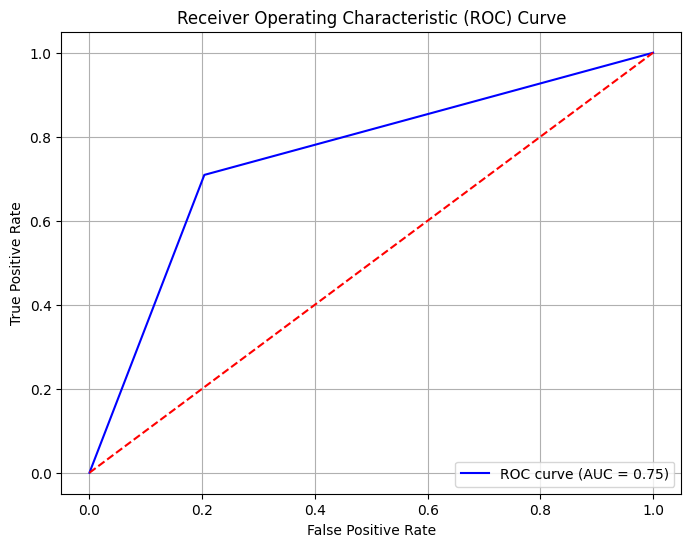

In [51]:
fpr, tpr, thresholds = roc_curve(y_test, y_predgb)
auc = roc_auc_score(y_test,y_predgb)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Linha de referência
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()


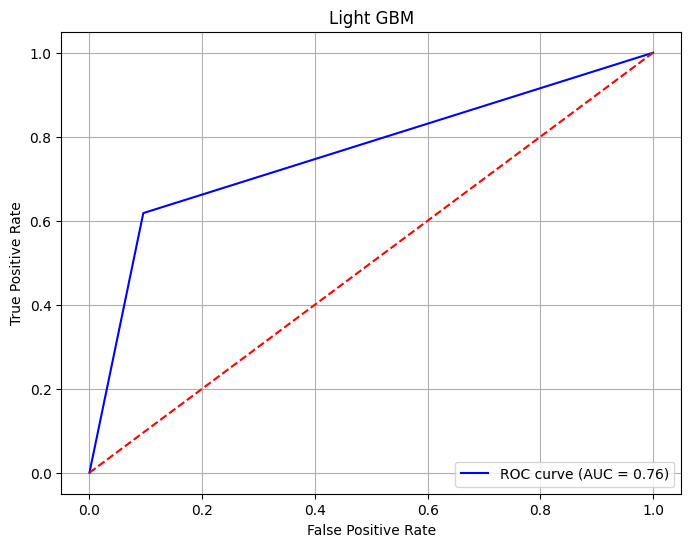

In [52]:
fpr,tpr,thresholds = roc_curve(y_test,y_predlgb)
rocauc = roc_auc_score(y_test,y_predlgb)
fig = plt.figure(figsize=(8,6))
plt.plot(fpr,tpr,color='blue',label=f"ROC curve (AUC = {rocauc:.2f})")
plt.plot([0,1],[0,1],color='red',linestyle='dashed')
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("Light GBM")
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [53]:
print(classification_report(y_true=y_test,y_pred=y_predgb))

              precision    recall  f1-score   support

           0       0.80      0.80      0.80       157
           1       0.71      0.71      0.71       110

    accuracy                           0.76       267
   macro avg       0.75      0.75      0.75       267
weighted avg       0.76      0.76      0.76       267



In [54]:
confusion_matrix(y_true=y_test,y_pred=y_predgb)

array([[125,  32],
       [ 32,  78]], dtype=int64)

In [55]:
print(classification_report(y_true=y_test,y_pred=y_predlgb))

              precision    recall  f1-score   support

           0       0.77      0.90      0.83       157
           1       0.82      0.62      0.70       110

    accuracy                           0.79       267
   macro avg       0.80      0.76      0.77       267
weighted avg       0.79      0.79      0.78       267



In [56]:
confusion_matrix(y_true=y_test,y_pred=y_predlgb)

array([[142,  15],
       [ 42,  68]], dtype=int64)

Com base nas métricas analisadas, é possível observar que o modelo LightGBM apresenta um comportamento mais conservador. Ele tende a errar mais ao prever a classe "0" (não sobreviventes), sendo menos eficaz em identificar corretamente as pessoas que sobreviveram. Isso ocorre porque o modelo prioriza prever que "alguém morreu" em vez de "alguém sobreviveu". Dado que a classe de sobrevivência é minoritária (há significativamente mais mortos do que sobreviventes no conjunto de dados), o LightGBM pode alcançar uma acurácia maior ao considerar toda a base de dados, mas com uma limitação em identificar sobreviventes.

Por outro lado, o modelo Gaussian Naive Bayes (GaussianNB) se destaca por sua capacidade de identificar mais corretamente as pessoas que sobreviveram. A escolha entre esses modelos deve levar em conta o objetivo da aplicação. Se o objetivo for identificar todos os sobreviventes, mesmo que isso resulte em alguns falsos positivos (erro ao classificar alguém como sobrevivente quando não é), o GaussianNB seria mais adequado. Por outro lado, se o objetivo for identificar com maior precisão os não sobreviventes, minimizando falsos positivos (erro ao classificar alguém como sobrevivente quando na verdade morreu), o LightGBM seria a escolha mais apropriada.

**Decisão em um Contexto Real**

Em um cenário real, como operações de resgate ou priorização de recursos para sobreviventes, o foco geralmente está em reduzir ao máximo o risco de deixar sobreviventes não identificados. Nesse caso, priorizar o modelo GaussianNB seria mais vantajoso, pois é preferível direcionar esforços adicionais na busca de sobreviventes, mesmo ao custo de lidar com alguns falsos positivos. Por outro lado, se o objetivo for reduzir custos ou esforços desnecessários com foco em precisão para identificar fatalidades, o LightGBM poderia ser mais útil.

**Análise da Curva ROC**

A curva ROC fornece informações valiosas sobre o desempenho dos dois modelos em diferentes limiares de decisão. Inicialmente, com um pequeno custo em termos de falsos positivos, o LightGBM apresenta melhor desempenho. Isso significa que, em situações onde é necessário prever um número limitado de sobreviventes, minimizando falsos positivos (como para reduzir esforços operacionais), o LightGBM é uma escolha interessante.

No entanto, conforme aumentamos o limiar e, consequentemente, o número de falsos positivos, o GaussianNB mostra uma inclinação mais acentuada na curva ROC, indicando que ele tem um melhor desempenho em cenários onde é aceitável lidar com mais falsos positivos para maximizar a detecção de sobreviventes. Portanto, se o objetivo for aumentar a cobertura de sobreviventes identificados, mesmo ao custo de mais falsos positivos, o GaussianNB se torna a escolha mais indicada.

**Conclusão**

A decisão sobre qual modelo utilizar depende diretamente do propósito do problema e das implicações práticas de cada erro (falsos positivos e falsos negativos). No contexto do Titanic, onde salvar vidas seria a prioridade, o GaussianNB demonstra ser mais eficaz, pois aumenta a probabilidade de identificar sobreviventes. Contudo, em aplicações onde o custo dos falsos positivos é crítico, o LightGBM pode ser a opção ideal.